In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "AP2"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn015881,MAYMNNWLGFSLSPQEHQNPQDHSQNSVSRLGFNTDKISGTDVSSD...,650,1
1,Achn066211,MLDLNLTAMPTDSISDGQMDDSGASNSSLLNVETSSVAVDEESSST...,405,1
2,Achn082221,MLDLNLSFARDEEYVSITEKFPEGSGGGAMDESGTSNSSIVNAEDD...,375,1
3,Achn088601,MEMITLVKSEVSPVRRRLCEMERDQKQPQQLLVDKSSATNTTVKRS...,312,1
4,Achn108581,MLDLNLSVVHNEDDSMEITNKFPEGSEGQMADSGTSTSSVVNAEGS...,426,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
8289,0.013216,0.00000,0.006608,0.004405,0.000000,0.011013,0.000000,0.002203,0.004405,0.002203,...,0.002203,0.006608,0.004405,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.0
7638,0.002433,0.00365,0.003650,0.006083,0.003650,0.002433,0.003650,0.002433,0.003650,0.004866,...,0.000000,0.001217,0.001217,0.000000,0.00365,0.00365,0.001217,0.0,0.0,0.0
7601,0.003521,0.00000,0.003521,0.007042,0.003521,0.000000,0.000000,0.003521,0.003521,0.003521,...,0.000000,0.003521,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.0
8799,0.004566,0.00000,0.000000,0.009132,0.004566,0.000000,0.004566,0.000000,0.000000,0.004566,...,0.000000,0.000000,0.000000,0.004566,0.00000,0.00000,0.000000,0.0,0.0,0.0
8759,0.008798,0.00000,0.002933,0.005865,0.005865,0.000000,0.000000,0.002933,0.000000,0.011730,...,0.002933,0.000000,0.000000,0.000000,0.00000,0.00000,0.002933,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 441)
X_test: (1779, 441)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 58s 667ms/step - accuracy: 0.5000 - loss: 0.6932

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6395 - loss: 0.6877   

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7135 - loss: 0.6542

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7601 - loss: 0.5926

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7714 - loss: 0.5730 - val_accuracy: 0.9459 - val_loss: 0.1426


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.1124

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1256 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9505 - loss: 0.1183

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9534 - loss: 0.1138

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9546 - loss: 0.1115 - val_accuracy: 0.9592 - val_loss: 0.1076


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0232

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9797 - loss: 0.0658 

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9778 - loss: 0.0671

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9758 - loss: 0.0705

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 0.0715 - val_accuracy: 0.9621 - val_loss: 0.1001


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0426

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9808 - loss: 0.0636 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9783 - loss: 0.0656

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9774 - loss: 0.0664

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9769 - loss: 0.0674 - val_accuracy: 0.9431 - val_loss: 0.1832


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0896

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9760 - loss: 0.0700 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9766 - loss: 0.0685

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9761 - loss: 0.0695

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9763 - loss: 0.0690 - val_accuracy: 0.9642 - val_loss: 0.1057


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0273

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0413 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0428

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.0442

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0453 - val_accuracy: 0.9606 - val_loss: 0.1162


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.1989

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9720 - loss: 0.0808 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9765 - loss: 0.0690

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9790 - loss: 0.0620

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.0599 - val_accuracy: 0.9628 - val_loss: 0.1176


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0264

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0293 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0343

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0377

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0393 - val_accuracy: 0.9599 - val_loss: 0.1249


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0489

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0438 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0408

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0395

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0389 - val_accuracy: 0.9642 - val_loss: 0.1118


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0137

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0215 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0201

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0217

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0230 - val_accuracy: 0.9536 - val_loss: 0.1603


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0135

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9808 - loss: 0.0485 

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.0421

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9859 - loss: 0.0392

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0378 - val_accuracy: 0.9663 - val_loss: 0.1178


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0038

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0138 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0169

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0180

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0190 - val_accuracy: 0.9656 - val_loss: 0.1157


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0052

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0133 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0154

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0188

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0200 - val_accuracy: 0.9613 - val_loss: 0.1260


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0052

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0272 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0262

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0254

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0248 - val_accuracy: 0.9670 - val_loss: 0.1283


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0168

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0095 

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0103

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0108

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0111 - val_accuracy: 0.9663 - val_loss: 0.1237


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0015

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0159 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0153

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0143

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0140 - val_accuracy: 0.9698 - val_loss: 0.1369


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0042

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0095 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0128

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0155

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0161 - val_accuracy: 0.9642 - val_loss: 0.1363


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0033

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0079 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0079

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0080

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0081 - val_accuracy: 0.9628 - val_loss: 0.1637


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0012

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0038 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0067

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0075

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9656 - val_loss: 0.1407


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0040

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0027 

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0031

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0033

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0033 - val_accuracy: 0.9656 - val_loss: 0.1727


Epoch 21/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.8243e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0063     

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0049

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0048

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0052 - val_accuracy: 0.9438 - val_loss: 0.2941


Epoch 22/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.1300

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0409 

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0411

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0377

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0361 - val_accuracy: 0.9663 - val_loss: 0.1373


Epoch 23/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0038

27/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0027 

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0031

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0036

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0042 - val_accuracy: 0.9670 - val_loss: 0.1494


Epoch 24/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0043

25/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0103 

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0102

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9969 - loss: 0.0095

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0089

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0087

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - loss: 0.0082

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0081 - val_accuracy: 0.9691 - val_loss: 0.1558


Epoch 25/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0017

11/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0027 

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0027

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0031

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0033

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0033 - val_accuracy: 0.9670 - val_loss: 0.1659


Epoch 26/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.0015e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0018     

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0016

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0017

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0019 - val_accuracy: 0.9613 - val_loss: 0.2154



[Train Accuracy: 99.84% - Test Accuracy: 96.01%]


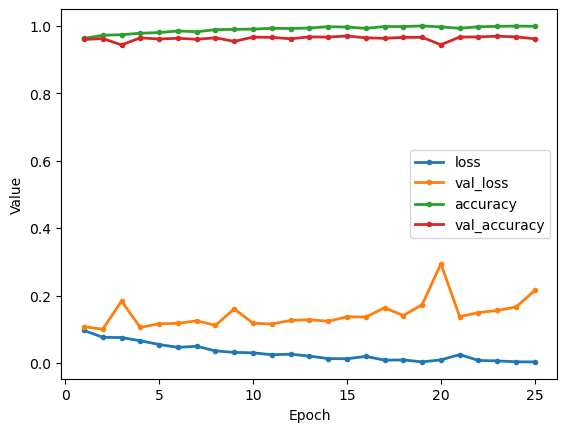

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
8289,0.002208,0.0,0.002208,0.002208,0.000000,0.002208,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7638,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.001218,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7601,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8799,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.004587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8759,0.000000,0.0,0.000000,0.000000,0.002941,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7115, 8898)
X_test: (1779, 8898)
y_train: (7115,)
y_test: (1779,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,278,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,321,409 (8.86 MB)

 Trainable params: 2,321,409 (8.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1:12 820ms/step - accuracy: 0.4688 - loss: 0.6932

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4939 - loss: 0.6929    

13/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5080 - loss: 0.6926

19/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5371 - loss: 0.6916

26/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5761 - loss: 0.6892 

33/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6115 - loss: 0.6848

40/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6407 - loss: 0.6777

47/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6654 - loss: 0.6671

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6862 - loss: 0.6533

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7042 - loss: 0.6374

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7198 - loss: 0.6202

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7334 - loss: 0.6030

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7455 - loss: 0.5860

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7563 - loss: 0.5696

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7578 - loss: 0.5674 - val_accuracy: 0.9719 - val_loss: 0.0673


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9844 - loss: 0.0370

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9781 - loss: 0.0620 

10/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9778 - loss: 0.0632

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9798 - loss: 0.0604

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9807 - loss: 0.0587

28/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9807 - loss: 0.0582

34/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9805 - loss: 0.0578

41/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9801 - loss: 0.0579

49/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9799 - loss: 0.0574

56/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9800 - loss: 0.0567 

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9800 - loss: 0.0562

70/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9802 - loss: 0.0556

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9804 - loss: 0.0549

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9806 - loss: 0.0544

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9808 - loss: 0.0540 - val_accuracy: 0.9768 - val_loss: 0.0572


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0081

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9928 - loss: 0.0361 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9936 - loss: 0.0301

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9936 - loss: 0.0270

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0247

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9942 - loss: 0.0230

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9945 - loss: 0.0216

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9948 - loss: 0.0205

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9950 - loss: 0.0196

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9951 - loss: 0.0189

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9953 - loss: 0.0183

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9954 - loss: 0.0178

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9955 - loss: 0.0174

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9955 - loss: 0.0173 - val_accuracy: 0.9775 - val_loss: 0.0702


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0043

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0040 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0045

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0048

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0048

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0047

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0047

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0047

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0047

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0048

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0048

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0048

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0049

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.9824 - val_loss: 0.0691


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0012

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0017

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0018

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9817 - val_loss: 0.0728


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 4.7605e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6556e-04 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8652e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0994e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2248e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4830e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8768e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 7.4471e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 7.8388e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 8.1045e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 8.2840e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 8.4109e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 8.6209e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - loss: 9.2164e-04 - val_accuracy: 0.9789 - val_loss: 0.0838


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.9354e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7871e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0016    

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0028

32/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0032

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0032

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0032

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0032

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0033

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0033

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0033

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0033

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0032

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9992 - loss: 0.0032 - val_accuracy: 0.9796 - val_loss: 0.0798


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 9.9657e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4380e-04 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9777e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.3554e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8790e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5332e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2370e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1039e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9929e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8869e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8397e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8099e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8174e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.8211e-04 - val_accuracy: 0.9803 - val_loss: 0.0851


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 2.9892e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7538e-04 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1808e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2460e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1957e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1556e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1010e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0725e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0535e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0359e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0145e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9871e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9521e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.9300e-04 - val_accuracy: 0.9824 - val_loss: 0.0887


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.5144e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7255e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6393e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5749e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5656e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5556e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5361e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5109e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4878e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4744e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4831e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4942e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5112e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.5164e-04 - val_accuracy: 0.9824 - val_loss: 0.0924


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 1.2048e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2271e-04 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1434e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8441e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5988e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4257e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2988e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1909e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0966e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0241e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9629e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9103e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8644e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.8471e-04 - val_accuracy: 0.9831 - val_loss: 0.0962


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.6339e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6276e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7421e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8746e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7032e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0254e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0885e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0380e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9629e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9145e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.8814e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8761e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8549e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.8275e-05 - val_accuracy: 0.9817 - val_loss: 0.1004


Epoch 13/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 4.3751e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.2513e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3506e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4091e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7342e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1350e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3827e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6053e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8073e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9161e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9519e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9274e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8678e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.8335e-05 - val_accuracy: 0.9824 - val_loss: 0.1036


Epoch 14/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.4101e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9949e-05 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8917e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9834e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9484e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9151e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8730e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8175e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8328e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8737e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8861e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9312e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0018e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.0188e-05 - val_accuracy: 0.9824 - val_loss: 0.1055


Epoch 15/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.4560e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1826e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6024e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9903e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6651e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4815e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3879e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2968e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2486e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1992e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2112e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2033e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1822e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.1769e-05 - val_accuracy: 0.9831 - val_loss: 0.1078


Epoch 16/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 6.4854e-06

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0371e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2871e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7665e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0188e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1794e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2989e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4002e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4860e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5417e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6074e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7174e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7838e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.8067e-05 - val_accuracy: 0.9817 - val_loss: 0.1120


Epoch 17/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.6562e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0817e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7918e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0054e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7732e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5390e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2856e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0651e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8851e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7182e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5575e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4231e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3095e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.2292e-05 - val_accuracy: 0.9824 - val_loss: 0.1125


Epoch 18/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.6021e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8176e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1083e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0273e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9661e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9274e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9427e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9603e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9509e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9247e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8922e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8562e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8865e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.9008e-05 - val_accuracy: 0.9824 - val_loss: 0.1159


Epoch 19/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.0066e-06

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9288e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6412e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0616e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2245e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2820e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2474e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1897e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1394e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0831e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0241e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9615e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8992e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.8816e-05 - val_accuracy: 0.9831 - val_loss: 0.1162


Epoch 20/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.6294e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1927e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4082e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6394e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9238e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0431e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1213e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1726e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1865e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2005e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2075e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2072e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2067e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.2061e-05 - val_accuracy: 0.9824 - val_loss: 0.1173


Epoch 21/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 7.6634e-06

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5677e-05 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3320e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8685e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9511e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8304e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7254e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6415e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5405e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4478e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3585e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2664e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1752e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.1500e-05 - val_accuracy: 0.9838 - val_loss: 0.1194


Epoch 22/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 4.9814e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6820e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4282e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3649e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2179e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1257e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1664e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1897e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2444e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2687e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2817e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2965e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.3015e-05 - val_accuracy: 0.9824 - val_loss: 0.1214


Epoch 23/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.3497e-06

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2231e-06 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6419e-06

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3601e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6881e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8567e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0825e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2066e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3189e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7657e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5202e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0988e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5652e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.7496e-05 - val_accuracy: 0.9824 - val_loss: 0.1230


Epoch 24/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 3.8453e-06

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5028e-06 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0688e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3583e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8835e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0132e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5596e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7876e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3812e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4183e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 3.9869e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 5.4703e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 6.7870e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9997 - loss: 7.3570e-04 - val_accuracy: 0.9487 - val_loss: 0.2602


Epoch 25/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0212

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0079 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0056

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0045

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0038

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0034

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0031

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0031

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0034

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0037

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0038

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0039

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0040

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9996 - loss: 0.0040 - val_accuracy: 0.9726 - val_loss: 0.1380


Epoch 26/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0048

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0047 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0039

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0034

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0031

36/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0030

43/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0030

50/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0029

57/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0029

64/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0030

71/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0032

78/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0033

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0034

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9988 - loss: 0.0034 - val_accuracy: 0.9754 - val_loss: 0.1156


Epoch 27/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 9.2419e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8100e-04 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0014    

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0030

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0036

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0039

45/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0041

53/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0042

61/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0042

68/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0043

75/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0045

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0046

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9984 - loss: 0.0046 - val_accuracy: 0.9789 - val_loss: 0.0955


Epoch 28/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.6516e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2352e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7705e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3089e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4585e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4827e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4577e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4001e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3350e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2503e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1781e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1044e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0323e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.0153e-04 - val_accuracy: 0.9796 - val_loss: 0.1163


Epoch 29/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.4076e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3515e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9798e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7134e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0490e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7795e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9812e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0375e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0178e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0147e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0700e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0836e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0830e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.0822e-05 - val_accuracy: 0.9810 - val_loss: 0.1249


Epoch 30/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 1.0323e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5907e-05 

15/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4133e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5681e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7298e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7922e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7610e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6908e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6264e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5910e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5458e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4912e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4405e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.4140e-05 - val_accuracy: 0.9796 - val_loss: 0.1318


Epoch 31/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.3016e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0921e-05 

16/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9922e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9712e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9182e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0979e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2592e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4658e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5636e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6102e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6473e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6730e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7292e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.8112e-05 - val_accuracy: 0.9796 - val_loss: 0.1382



[Train Accuracy: 100.00% - Test Accuracy: 97.86%]


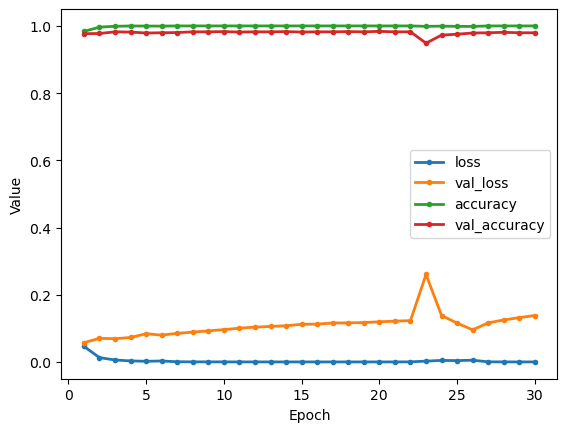

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

44/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
8289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,890,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,931,457 (148.51 MB)

 Trainable params: 38,931,457 (148.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 1:18 895ms/step - accuracy: 0.3906 - loss: 0.6932

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.4180 - loss: 0.6931 

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.4349 - loss: 0.6931

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.4443 - loss: 0.6930

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.4542 - loss: 0.6929

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.4597 - loss: 0.6929

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.4642 - loss: 0.6928

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.4691 - loss: 0.6927

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.4743 - loss: 0.6926

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.4775 - loss: 0.6924

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.4793 - loss: 0.6923

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.4810 - loss: 0.6922

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.4834 - loss: 0.6921

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.4859 - loss: 0.6919 

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.4885 - loss: 0.6918

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.4918 - loss: 0.6915

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.4953 - loss: 0.6913

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.4989 - loss: 0.6911

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.5025 - loss: 0.6908

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.5063 - loss: 0.6905

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.5105 - loss: 0.6902

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5151 - loss: 0.6899

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5200 - loss: 0.6895

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5250 - loss: 0.6891

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5302 - loss: 0.6887

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5354 - loss: 0.6882

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5407 - loss: 0.6877

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5459 - loss: 0.6872

29/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5510 - loss: 0.6866

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5561 - loss: 0.6860

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5612 - loss: 0.6854

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5662 - loss: 0.6847

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5711 - loss: 0.6839

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.5760 - loss: 0.6831

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.5808 - loss: 0.6822

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.5855 - loss: 0.6813

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.5901 - loss: 0.6803

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.5946 - loss: 0.6793

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.5990 - loss: 0.6782

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.6033 - loss: 0.6770

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.6075 - loss: 0.6758

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.6116 - loss: 0.6745

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.6156 - loss: 0.6732

44/89 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6195 - loss: 0.6718

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6233 - loss: 0.6704

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6271 - loss: 0.6689

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6307 - loss: 0.6673

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6343 - loss: 0.6657

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6378 - loss: 0.6640

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6412 - loss: 0.6623

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6446 - loss: 0.6605

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.6478 - loss: 0.6586

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.6510 - loss: 0.6567

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.6541 - loss: 0.6547

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.6572 - loss: 0.6527

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6602 - loss: 0.6507

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.6631 - loss: 0.6485

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.6660 - loss: 0.6464

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6688 - loss: 0.6442

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6716 - loss: 0.6420

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6743 - loss: 0.6398

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6769 - loss: 0.6375

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6795 - loss: 0.6353

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6820 - loss: 0.6330

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6845 - loss: 0.6307

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6870 - loss: 0.6284

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.6893 - loss: 0.6261

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.6917 - loss: 0.6238

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.6940 - loss: 0.6215

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.6962 - loss: 0.6191

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.6985 - loss: 0.6167

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.7006 - loss: 0.6144

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.7028 - loss: 0.6120

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7049 - loss: 0.6097

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7070 - loss: 0.6073

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7090 - loss: 0.6050

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7110 - loss: 0.6026

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7129 - loss: 0.6003

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7149 - loss: 0.5979

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7167 - loss: 0.5956

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7186 - loss: 0.5933

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7204 - loss: 0.5910

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7222 - loss: 0.5887

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7240 - loss: 0.5864

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7258 - loss: 0.5841

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7275 - loss: 0.5819

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7292 - loss: 0.5796

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7308 - loss: 0.5774

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7325 - loss: 0.5751

89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.7341 - loss: 0.5729 - val_accuracy: 0.9684 - val_loss: 0.0703


Epoch 2/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.9844 - loss: 0.0342

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.9883 - loss: 0.0285

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.9905 - loss: 0.0257

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.9919 - loss: 0.0240

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.9916 - loss: 0.0243

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9908 - loss: 0.0254

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9899 - loss: 0.0287

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9892 - loss: 0.0318

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9887 - loss: 0.0339

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9883 - loss: 0.0355

11/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9878 - loss: 0.0369

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9875 - loss: 0.0379

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.9873 - loss: 0.0384

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9872 - loss: 0.0388

15/89 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9872 - loss: 0.0391

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9872 - loss: 0.0392

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9872 - loss: 0.0392

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9872 - loss: 0.0394

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9871 - loss: 0.0395

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9872 - loss: 0.0395

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9872 - loss: 0.0395

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9873 - loss: 0.0394 

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9873 - loss: 0.0394

24/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9873 - loss: 0.0393

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9873 - loss: 0.0393

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9873 - loss: 0.0392

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9874 - loss: 0.0391

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9874 - loss: 0.0390

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9875 - loss: 0.0388

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9875 - loss: 0.0387

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9876 - loss: 0.0385

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9877 - loss: 0.0384

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9878 - loss: 0.0382

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9879 - loss: 0.0380

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9880 - loss: 0.0378

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9881 - loss: 0.0376

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9882 - loss: 0.0374

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9882 - loss: 0.0372

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9883 - loss: 0.0370

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9884 - loss: 0.0368

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9885 - loss: 0.0366

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9885 - loss: 0.0364

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9886 - loss: 0.0362

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9886 - loss: 0.0360

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9887 - loss: 0.0359

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9888 - loss: 0.0357

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9888 - loss: 0.0355

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9889 - loss: 0.0353

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9890 - loss: 0.0351

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9890 - loss: 0.0350

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9891 - loss: 0.0348

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9891 - loss: 0.0346

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9892 - loss: 0.0345

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9892 - loss: 0.0343

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9893 - loss: 0.0341

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9893 - loss: 0.0340

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9894 - loss: 0.0339

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9894 - loss: 0.0337

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9895 - loss: 0.0336

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9895 - loss: 0.0335

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9895 - loss: 0.0333

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9896 - loss: 0.0332

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9896 - loss: 0.0331

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9896 - loss: 0.0330

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9896 - loss: 0.0329

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9897 - loss: 0.0328

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9897 - loss: 0.0326

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9897 - loss: 0.0325

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9897 - loss: 0.0324

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9898 - loss: 0.0323

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9898 - loss: 0.0322

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9898 - loss: 0.0321

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9898 - loss: 0.0320

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9899 - loss: 0.0319

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9899 - loss: 0.0319

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9899 - loss: 0.0318

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9899 - loss: 0.0317

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9899 - loss: 0.0316

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9900 - loss: 0.0316

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9900 - loss: 0.0315

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9900 - loss: 0.0314

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9900 - loss: 0.0313

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9900 - loss: 0.0312

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9901 - loss: 0.0312

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9901 - loss: 0.0311

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9901 - loss: 0.0310

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9901 - loss: 0.0309

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9901 - loss: 0.0308

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9902 - loss: 0.0308

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.9902 - loss: 0.0307 - val_accuracy: 0.9789 - val_loss: 0.0485


Epoch 3/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 1.0000 - loss: 0.0047

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 0.9961 - loss: 0.0093

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.9957 - loss: 0.0096

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.9958 - loss: 0.0093

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9954 - loss: 0.0094

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9953 - loss: 0.0093

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9953 - loss: 0.0093

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9954 - loss: 0.0091

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9955 - loss: 0.0089

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9957 - loss: 0.0087

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9958 - loss: 0.0086

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9959 - loss: 0.0084

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9961 - loss: 0.0082

14/89 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9962 - loss: 0.0080 

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9963 - loss: 0.0078

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.9964 - loss: 0.0077

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9965 - loss: 0.0075

18/89 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9966 - loss: 0.0074

19/89 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9967 - loss: 0.0072

20/89 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9968 - loss: 0.0071

21/89 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9969 - loss: 0.0070

22/89 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9969 - loss: 0.0069

23/89 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9970 - loss: 0.0067

24/89 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9971 - loss: 0.0066

25/89 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9972 - loss: 0.0065 

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9972 - loss: 0.0064

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9973 - loss: 0.0064

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.9973 - loss: 0.0063

29/89 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.9974 - loss: 0.0062

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9974 - loss: 0.0061

31/89 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9975 - loss: 0.0061

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.9975 - loss: 0.0060

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9976 - loss: 0.0059

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9976 - loss: 0.0059

35/89 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9977 - loss: 0.0058

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9977 - loss: 0.0058

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9978 - loss: 0.0058

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9978 - loss: 0.0057

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9978 - loss: 0.0057

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9979 - loss: 0.0056

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9979 - loss: 0.0056

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9979 - loss: 0.0056

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9980 - loss: 0.0055

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9980 - loss: 0.0056

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9980 - loss: 0.0056

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9980 - loss: 0.0056

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9980 - loss: 0.0057

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9980 - loss: 0.0057

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9980 - loss: 0.0057

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9981 - loss: 0.0057

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9981 - loss: 0.0057

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9981 - loss: 0.0058

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9981 - loss: 0.0058

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9981 - loss: 0.0058

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9981 - loss: 0.0058

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9981 - loss: 0.0058

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9981 - loss: 0.0058

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9982 - loss: 0.0058

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9982 - loss: 0.0058

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9982 - loss: 0.0058

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9982 - loss: 0.0058

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9982 - loss: 0.0058

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9982 - loss: 0.0058

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9982 - loss: 0.0058

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9983 - loss: 0.0058

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9983 - loss: 0.0058

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9983 - loss: 0.0058

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.9983 - loss: 0.0058

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9983 - loss: 0.0058

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9983 - loss: 0.0058

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9983 - loss: 0.0058

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9983 - loss: 0.0058

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9983 - loss: 0.0058

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9984 - loss: 0.0058

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9984 - loss: 0.0058

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9984 - loss: 0.0058

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9984 - loss: 0.0057

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9984 - loss: 0.0057

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9984 - loss: 0.0057

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9984 - loss: 0.0057

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9984 - loss: 0.0057

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9984 - loss: 0.0057

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9984 - loss: 0.0057

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9985 - loss: 0.0057

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9985 - loss: 0.0057

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9985 - loss: 0.0057

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9985 - loss: 0.0057

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9985 - loss: 0.0057

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9985 - loss: 0.0057

89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9712 - val_loss: 0.0916


Epoch 4/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 1.0000 - loss: 3.5416e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 3.7280e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.2641e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 4.6635e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.8768e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 5.0128e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 5.0881e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 5.1070e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 5.1865e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 5.2692e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 5.3335e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 5.4069e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 5.4895e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 5.5515e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 5.6166e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 5.6686e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 5.7152e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 5.7794e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 5.8404e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 5.8942e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 5.9746e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 6.0481e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 6.1125e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 6.1982e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 6.2926e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 6.3753e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 6.4475e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 6.5153e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 6.5759e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 6.6291e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 6.6768e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 6.7228e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 6.7786e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 6.8646e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 6.9476e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 7.0234e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 7.0985e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 7.1711e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 7.2376e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 7.2982e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 7.3638e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 7.4339e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 7.5532e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 7.6637e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 7.7656e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 7.8618e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 7.9516e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 8.0342e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 8.1110e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 8.1817e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 8.2539e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 8.3201e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 8.3859e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 8.4463e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 8.5079e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 8.5655e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 8.6219e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 8.6750e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 8.7246e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 8.7700e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 8.8119e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 8.8514e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 8.8939e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 8.9339e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 8.9706e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 9.0045e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 9.0367e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 9.0673e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 9.0981e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 9.1296e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 9.1590e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 9.1867e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 9.2129e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 9.2386e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 9.2630e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 9.2856e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 9.3067e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 9.3269e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 9.3550e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 9.3819e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 9.4068e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 9.4297e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 9.4517e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 9.4729e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 9.4927e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 9.5112e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 9.5299e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 9.5500e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 9.5690e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 9.5876e-04 - val_accuracy: 0.9761 - val_loss: 0.0676


Epoch 5/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 4.3955e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 5.2513e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 5.4429e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 5.3904e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 5.3146e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 5.1892e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 5.0752e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 4.9825e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 4.9034e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 4.8265e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 4.8058e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 4.8296e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 4.8357e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 4.8316e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 4.8237e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 4.8096e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 4.9333e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 5.0343e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 5.1147e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 5.1765e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 5.2277e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 5.2675e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 5.2983e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 5.3229e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 5.3459e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 5.3628e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 5.3757e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 5.4003e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 5.4181e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 5.4361e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 5.4518e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 5.4644e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 5.4751e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 5.4876e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 5.4972e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 5.5065e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.5148e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.5207e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.5249e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.5267e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.5279e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.5275e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.5299e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 5.5317e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5325e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5332e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5320e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5293e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5253e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5212e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5159e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.5098e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.5028e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.4956e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.4893e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.4827e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.4753e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.4671e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.4591e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.4507e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.4423e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.4345e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.4271e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.4194e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 5.4115e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 5.4040e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 5.3964e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 5.3908e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 5.3848e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 5.3781e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.3710e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.3636e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.3558e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.3477e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.3392e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.3314e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.3233e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.3153e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 5.3073e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 5.2996e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 5.2929e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 5.2861e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 5.2794e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 5.2726e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 5.2655e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 5.2582e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 5.2556e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 5.2527e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 5.2497e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 5.2467e-04 - val_accuracy: 0.9761 - val_loss: 0.0709


Epoch 6/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 1.0000 - loss: 1.2773e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.5940e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 2.0702e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 2.2354e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 2.3837e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 2.4738e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 2.5241e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 2.5397e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 2.5378e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 2.5446e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 2.5404e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.5290e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.5157e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 2.5202e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.5183e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 2.5127e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 2.5051e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 2.4952e-04 

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 2.4837e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.4726e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.4710e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.4726e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.4715e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 2.4795e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 2.4853e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 2.4898e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 2.4942e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 2.4965e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 2.4995e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 2.5004e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.5008e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.5016e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.5016e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.5010e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.4999e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.4989e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.4974e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 2.4953e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.4926e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.4936e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 2.4980e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 2.5017e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 2.5042e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 2.5056e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 2.5065e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.5104e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.5139e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.5168e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.5189e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.5207e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.5223e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.5235e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.5241e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.5248e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.5255e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.5266e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.5275e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.5280e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.5284e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.5285e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.5281e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.5286e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.5287e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.5283e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.5276e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.5266e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.5254e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.5243e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.5231e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.5216e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.5199e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.5179e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.5158e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.5141e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.5124e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.5105e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.5090e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.5074e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.5059e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.5044e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.5028e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.5013e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.4996e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.4986e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.4986e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.4983e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.4979e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.4973e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.4966e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.4959e-04 - val_accuracy: 0.9761 - val_loss: 0.0712


Epoch 7/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 1.0000 - loss: 9.8635e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.3171e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.5444e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.5629e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 1.5462e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 1.5433e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.5331e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 1.5209e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.5036e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.4921e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.4827e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.4712e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 1.4599e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 1.4475e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 1.4360e-04 

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 1.4237e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 1.4139e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 1.4069e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 1.3989e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 1.3899e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 1.3807e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 1.3714e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.3636e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.3645e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.3648e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.3650e-04

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.3676e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.3800e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.3903e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.3991e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.4086e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.4175e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.4252e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.4320e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.4395e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.4464e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 1.4527e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.4591e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.4646e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.4697e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.4743e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.4804e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.4858e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.4909e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.4965e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.5016e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.5061e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.5104e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.5142e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.5180e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.5213e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.5241e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.5265e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.5286e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.5302e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.5315e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.5327e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.5337e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.5343e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.5349e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.5352e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.5352e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.5351e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.5349e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.5346e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.5343e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.5338e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.5333e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.5328e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.5322e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.5316e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.5308e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.5300e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.5290e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.5279e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.5271e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5262e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5252e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5242e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5235e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.5226e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.5217e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.5208e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.5197e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.5187e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.5177e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.5166e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.5155e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.5143e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.5132e-04 - val_accuracy: 0.9761 - val_loss: 0.0741


Epoch 8/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 1.0000 - loss: 4.1325e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.8199e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 3.4224e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 3.1741e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 2.9630e-04

 6/89 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.7854e-04

 7/89 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 1.0000 - loss: 2.6555e-04

 8/89 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 1.0000 - loss: 2.5709e-04

 9/89 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 1.0000 - loss: 2.4947e-04

10/89 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 1.0000 - loss: 2.4339e-04

11/89 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 1.0000 - loss: 2.3745e-04

12/89 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 1.0000 - loss: 2.3185e-04

13/89 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 1.0000 - loss: 2.2665e-04

14/89 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 1.0000 - loss: 2.2158e-04

15/89 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 1.0000 - loss: 2.1777e-04

16/89 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 1.0000 - loss: 2.1392e-04

17/89 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 1.0000 - loss: 2.1016e-04

18/89 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 1.0000 - loss: 2.0717e-04

19/89 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 1.0000 - loss: 2.0443e-04

20/89 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 1.0000 - loss: 2.0170e-04

21/89 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 1.0000 - loss: 1.9901e-04

22/89 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 1.0000 - loss: 1.9635e-04

23/89 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 1.0000 - loss: 1.9389e-04

24/89 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 1.0000 - loss: 1.9147e-04

25/89 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 1.0000 - loss: 1.8909e-04

26/89 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 1.0000 - loss: 1.8678e-04 

27/89 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 1.0000 - loss: 1.8458e-04

28/89 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 1.0000 - loss: 1.8248e-04

29/89 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 1.0000 - loss: 1.8045e-04

30/89 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 1.0000 - loss: 1.7850e-04

31/89 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 1.0000 - loss: 1.7660e-04

32/89 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 1.0000 - loss: 1.7474e-04

33/89 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 1.0000 - loss: 1.7309e-04

34/89 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 1.7147e-04

35/89 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 1.6989e-04

36/89 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 1.6840e-04

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 1.6720e-04

38/89 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 1.6603e-04

39/89 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.6488e-04

40/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.6373e-04

41/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.6262e-04

42/89 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 1.6156e-04

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 1.6052e-04

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.5953e-04

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.5857e-04

46/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.5763e-04

47/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.5671e-04

48/89 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.5584e-04

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5499e-04

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5413e-04

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5331e-04

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.5252e-04

53/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.5174e-04

54/89 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.5097e-04

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.5025e-04

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.4954e-04

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.4892e-04

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.4829e-04

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.4767e-04

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.4709e-04

61/89 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 1.4651e-04

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.4594e-04

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.4541e-04

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.4489e-04

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.4435e-04

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.4384e-04

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.4334e-04

68/89 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.4286e-04

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.4238e-04

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.4190e-04

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.4143e-04

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.4096e-04

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.4050e-04

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.4005e-04

75/89 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.3961e-04

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.3917e-04

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.3874e-04

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.3831e-04

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.3789e-04

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.3747e-04

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.3706e-04

82/89 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.3665e-04

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.3624e-04

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.3585e-04

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.3546e-04

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.3510e-04

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.3475e-04

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.3443e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.3411e-04

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 1.0000 - loss: 1.3380e-04 - val_accuracy: 0.9761 - val_loss: 0.0782


Epoch 9/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 1.0000 - loss: 4.1603e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 4.5098e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 4.5024e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 4.3508e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 4.5988e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 4.8114e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 4.9157e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 4.9736e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 4.9991e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 5.0262e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 5.0358e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 5.0258e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 5.1003e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 5.1562e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 5.2465e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 5.3422e-05 

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.4380e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 5.5126e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.6041e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 5.6817e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 5.7508e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 5.8064e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 5.8484e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 5.8880e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 5.9256e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 5.9978e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.1062e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.2032e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.2913e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.3671e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.4357e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.4937e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.5442e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.6014e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.6503e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.7271e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.7972e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.8616e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.9312e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 6.9946e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 7.0517e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 7.1172e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 7.1775e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 7.2356e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 7.2893e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 7.3393e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 7.3837e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 7.4242e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 7.4603e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 7.5016e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 7.5400e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 7.5755e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 7.6076e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 7.6367e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 7.6641e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 7.6907e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 7.7154e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 7.7385e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 7.7601e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 7.7808e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 7.8006e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 7.8227e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.8423e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.8610e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.8796e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.8969e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.9127e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.9286e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.9450e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.9612e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.9761e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.9896e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 8.0029e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 8.0149e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 8.0266e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 8.0371e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 8.0468e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 8.0553e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 8.0629e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 8.0700e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 8.0764e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 8.0856e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 8.0943e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 8.1020e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 8.1087e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 8.1151e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 8.1233e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 8.1307e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 8.1390e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 8.1471e-05 - val_accuracy: 0.9768 - val_loss: 0.0749


Epoch 10/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step - accuracy: 1.0000 - loss: 1.5283e-04

 2/89 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 1.0000 - loss: 1.2211e-04

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 1.0953e-04

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 1.0016e-04

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 9.2656e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 8.6347e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 8.3381e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 8.5222e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 8.6129e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 8.9404e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 9.1429e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 9.2479e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 9.3519e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 9.4337e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 9.4957e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 9.5397e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 9.5550e-05 

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 9.5948e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 9.6142e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 9.6172e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 9.6458e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 9.6603e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 9.6652e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 9.6631e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 9.6586e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 9.6451e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 9.6322e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 9.6169e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 9.5965e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 1.0000 - loss: 9.5728e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 9.5625e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 9.5460e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 9.5284e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 9.5061e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 9.4805e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 9.4530e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 9.4232e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 9.3924e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 9.3594e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 9.3257e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 9.2955e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 9.2631e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 9.2294e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 9.1952e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 9.1605e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 9.1260e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 9.0907e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 9.0554e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 9.0193e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 8.9827e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 8.9590e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 8.9347e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 8.9109e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 8.8862e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 8.8617e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 8.8378e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 8.8158e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 8.8006e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 8.7916e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.7824e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.7720e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.7620e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.7511e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.7395e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.7268e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 8.7137e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.7005e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.6888e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.6789e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.6695e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.6594e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.6485e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.6367e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 8.6242e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.6117e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.5990e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.5861e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.5765e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.5665e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.5559e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.5447e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.5329e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.5206e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.5084e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.4958e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.4860e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.4758e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.4653e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.4544e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 8.4438e-05 - val_accuracy: 0.9768 - val_loss: 0.0821


Epoch 11/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 1.0000 - loss: 2.1362e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 2.6140e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 3.2232e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 3.5545e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 3.6471e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 3.7768e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 3.8310e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 3.8453e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 3.8394e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 3.8150e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 3.8059e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 3.7928e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 3.8032e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 3.8084e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 3.8021e-05 

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 3.7914e-05

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 3.8250e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 3.8479e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 3.8629e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 3.9031e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 3.9402e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 3.9675e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 3.9965e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 4.0171e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 4.0384e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 4.0630e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 4.0847e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 4.1041e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 4.1194e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.1504e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.1797e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.2053e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.2320e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 4.2573e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.2808e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 4.3354e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.3883e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.4355e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.4834e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.5337e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.5799e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.6231e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 4.6634e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 4.7113e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.7551e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.7942e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.8298e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 4.8615e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.8970e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.9294e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.9585e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.9855e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 5.0100e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 5.0330e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 5.0545e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 5.0743e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 5.0923e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.1087e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.1234e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1372e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1502e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1637e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1762e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1873e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1976e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.2074e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2159e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2248e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2336e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2411e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2503e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2585e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2657e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.2721e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.2778e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.2828e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.2876e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.2975e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.3110e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.3240e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.3361e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.3474e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.3578e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.3677e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.3785e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.3899e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.4003e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.4106e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.4202e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.4295e-05 - val_accuracy: 0.9775 - val_loss: 0.0854


Epoch 12/100


 1/89 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 1.0000 - loss: 4.3413e-05

 2/89 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 4.3945e-05

 3/89 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 4.3243e-05

 4/89 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 4.3994e-05

 5/89 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.5957e-05

 6/89 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 6.1716e-05

 7/89 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 6.4291e-05

 8/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 6.6462e-05

 9/89 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 6.7677e-05

10/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.8275e-05

11/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.8367e-05

12/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.8195e-05

13/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.7822e-05

14/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.7254e-05

15/89 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 6.6603e-05

16/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 6.5864e-05 

17/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 6.5578e-05

18/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 6.5171e-05

19/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 6.4735e-05

20/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 6.4232e-05

21/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 6.3861e-05

22/89 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 6.3668e-05

23/89 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 6.3436e-05

24/89 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 6.3725e-05

25/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.3986e-05

26/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.4154e-05

27/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.4274e-05

28/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.4328e-05

29/89 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 6.4371e-05

30/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.4375e-05

31/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.4340e-05

32/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.4269e-05

33/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.4162e-05

34/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.4042e-05

35/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.3888e-05

36/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.3728e-05

37/89 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 6.3551e-05

38/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.3356e-05

39/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.3147e-05

40/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.2971e-05

41/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.2790e-05

42/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.2602e-05

43/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.2460e-05

44/89 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 6.2331e-05

45/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 6.2206e-05

46/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 6.2074e-05

47/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 6.1984e-05

48/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 6.1899e-05

49/89 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 6.1801e-05

50/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 6.1695e-05

51/89 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 6.1578e-05

52/89 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 6.1452e-05

53/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.1377e-05

54/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.1319e-05

55/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.1280e-05

56/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.1229e-05

57/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.1166e-05

58/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.1099e-05

59/89 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.1026e-05

60/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 6.0950e-05

61/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 6.0874e-05

62/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 6.0795e-05

63/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 6.0712e-05

64/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 6.0637e-05

65/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 6.0554e-05

66/89 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 6.0470e-05

67/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.0379e-05

68/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.0300e-05

69/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.0217e-05

70/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.0132e-05

71/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.0049e-05

72/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.9966e-05

73/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.9881e-05

74/89 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.9795e-05

75/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9713e-05

76/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9635e-05

77/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9561e-05

78/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9485e-05

79/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9412e-05

80/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9335e-05

81/89 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9253e-05

82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.9177e-05

83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.9096e-05

84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.9013e-05

85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.8927e-05

86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.8847e-05

87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.8765e-05

88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.8688e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 5.8613e-05

89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 5.8540e-05 - val_accuracy: 0.9775 - val_loss: 0.0872



[Train Accuracy: 100.00% - Test Accuracy: 98.37%]


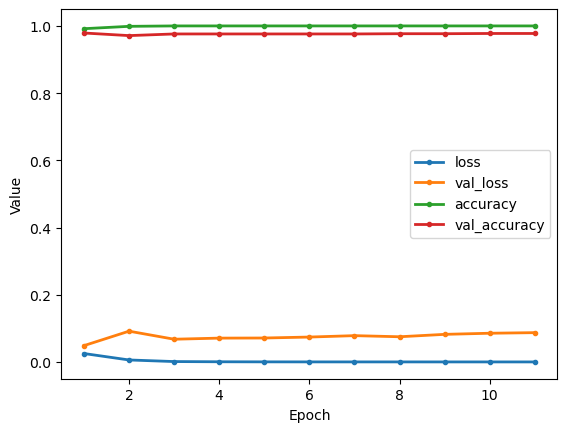

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step

 5/56 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

 9/56 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

13/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

21/56 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

30/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

35/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

40/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

45/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

49/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

53/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

 5/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

10/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

14/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

18/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

23/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

27/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

31/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

35/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

39/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

43/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

47/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

51/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/AP2/report_UA1IL89G.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################